In [3]:
import matplotlib.pyplot as plt
import autograd.numpy as np
import autograd.scipy.stats as sps_autograd
from autograd import grad, hessian, jacobian
from statsmodels.tsa.arima_process import ArmaProcess
from scipy.optimize import minimize
from scipy.linalg import toeplitz
import pandas as pd

In [4]:
"""
Simulate ARMA(1, 1) model
"""
a = 0.5
b = 0.2
# Define AR and MA coefficients
ar = np.array([1, -a])  
ma = np.array([1, -b])        

# Create ARMA process object
arma_process = ArmaProcess(ar, ma)

# Simulate 500 samples
N = 200
y = arma_process.generate_sample(nsample=N, scale=2) # scale is the variance of the white noise

In [5]:
def analytical_grad_hess(theta, init_sigma2):
    a, b = theta
    k = 2
    sigma2 = init_sigma2  # CHANGE PARAMETER HERE

    # Simple operations that autograd can handle
    F = np.array([[a, 1.0], [0.0, 0.0]])
    G = np.array([[1.0], [-b]])
    H = np.array([[1.0, 0.0]])
    Q = np.eye(k)
    dF = np.array([
        [[1, 0], [0, 0]],  # First parameter (AR coefficient)
        [[0, 0], [0, 0]]   # Second parameter (MA coefficient)
        ])
    dF.reshape(2, 2, 2)
    dG = np.array([
        [[0], [0]],  # First parameter (AR coefficient)
        [[0], [-1.0]]   # Second parameter (MA coefficient)
        ])
    dG.reshape(2, 2, 1)

    g = np.array([1.0, a - b, a * (a - b)])

    C = np.array([
        sigma2 * (1 - 2 * a * b + b**2) / (1 - a**2),
        a * (sigma2 * (1 - 2 * a * b + b**2) / (1 - a**2)) - sigma2 * b,
        a * (a * (sigma2 * (1 - 2 * a * b + b**2) / (1 - a**2)) - sigma2 * b)
    ])

    V = np.array([
        [C[0], -b * g[0]],
        [-b * g[0], b**2 * sigma2]
    ])

    dV = np.array([
        [[(2 * sigma2 * (a-b) * (1 - a*b)) / (1 - a**2)**2, 0],
        [0, 0]],
        [[2 * sigma2 * (b-a) / (1 - a**2), -1],
        [-1, 2 * b * sigma2]]
    ])

    # Initialize the x and dx
    x = np.zeros((k, 1))
    dx = np.zeros((2, 2, 1))

    # Dictionary to store the values
    dict = {
        'analytical_grad_at_i': [],
        'log_likelihood_at_i': [],
    }

    # Initialize the values
    sigma2_hat_sum = 0.0
    dsigma2_hat_sum = np.array([[0.0], [0.0]]).reshape(2, 1, 1)
    log_r_sum = 0.0


    # Run the Kalman filter for gradient
    for t in range(N):
        # Set the current sample size
        n = t + 1
        

        # 1. Predict
        # Predict one-step-ahead state predictive density of x_{t}
        x_predict = F @ x
        V_predict = F @ V @ F.T + G @ G.T

        # Compute forecast error and one-step-ahead predictive variance
        e_t = y[t] - (H @ x_predict)[0, 0]
        r_t = (H @ V_predict @ H.T)[0, 0]

        GdGT = np.array([G @ dG.T[0][i].reshape(1,2) for i in range(2)])

        # Kalman filter for gradient
        dx_predict = F @ dx + dF @ x
        dV_predict = F @ dV @ F.T + dF @ V @ F.T + F @ V @ dF.T + dG @ G.T + GdGT
        # dV_predict = F @ dV @ F.T + dF @ V @ F.T + F @ V @ dF.T + dG @ G.T + G @ Q @ dG.T


        # Calculate de_t and dr_t as tensor(2,1,1)
        de_t = -H @ dx_predict
        dr_t = H @ dV_predict @ H.T

        # Update sigma2 hat and gradient of sigma2 hat
        sigma2_hat_sum += e_t**2 / r_t
        sigma2_hat = sigma2_hat_sum / n
        dsigma2_hat_sum += (2 * e_t * de_t) /r_t - (e_t**2 * dr_t) / (r_t**2)
        dsigma2_hat = dsigma2_hat_sum / n

        # Update the r
        log_r_sum += np.log(r_t)

        # 2. Update
        # Kalman gain
        K = V_predict @ H.T / r_t

        # Update current state and covariance
        x = x_predict + K * e_t
        V = (np.eye(k) - K @ H) @ V_predict

        dK = (dV_predict @ H.T / r_t) - (V_predict @ H.T / r_t**2) @ dr_t
        dx = dx_predict + K @ de_t + dK * e_t
        dV = dV_predict - dK @ H @ V_predict - K @ H @ dV_predict
        
        # Compute sigma2_hat and gradient of the log-likelihood
        log_likelihood_at_i = -0.5 * (np.log(2 * np.pi) 
                                + np.log(sigma2_hat) 
                                + np.log(r_t) + e_t**2 / (r_t * sigma2_hat))  
        
        """
        analytical_grad = - (e_t * de_t) / (sigma2_hat * r_t) \
                                + (e_t**2 * dr_t) / (2 * sigma2_hat * r_t**2) \
                                - dr_t / (2 * r_t)
        """
        
        analytical_grad_at_i = - 0.5 * (dsigma2_hat / sigma2_hat 
                                    + dr_t / r_t 
                                    + (2 * e_t * sigma2_hat * r_t * de_t - e_t**2 * r_t * dsigma2_hat - e_t**2 * sigma2_hat * dr_t) / (sigma2_hat**2 * r_t**2)
                                    )
        

        dict['analytical_grad_at_i'].append(analytical_grad_at_i.flatten())
        dict['log_likelihood_at_i'].append(log_likelihood_at_i)

    log_likelihood = -0.5 * (N * np.log(2 * np.pi) 
                            + N * np.log(sigma2_hat) 
                            # + np.sum(np.log(r)) + N)
                            + log_r_sum + N)

    # Return the dictionary
    return dict, sigma2_hat, log_likelihood



In [6]:
# Initialize the parameters
theta = np.array([-0.2, 0.1])
init_sigma2 = 0.5

# Dataframe to store the results
df = pd.DataFrame(columns=['t', 'analytical_hess', 'auto_hess', 'equal'])

for t in range(N):
    # Analytical gradient
    obj_func_gradient = lambda param: analytical_grad_hess(param, init_sigma2)[0]['analytical_grad_at_i'][t]
    jacobian_obj_func_gradient = jacobian(obj_func_gradient)
    auto_jacobian_val = jacobian_obj_func_gradient(theta)

    # Auto Hessian
    obj_func_likelihood = lambda param: analytical_grad_hess(param, init_sigma2)[0]['log_likelihood_at_i'][t]
    hess_obj_func_likelihood = hessian(obj_func_likelihood)
    auto_hess_val = hess_obj_func_likelihood(theta)

    # Store the results
    df.loc[t, 't'] = t
    df.loc[t, 'analytical_hess'] = auto_jacobian_val
    df.loc[t, 'auto_hess'] = auto_hess_val
    df.loc[t, 'equal'] = np.allclose(auto_jacobian_val, auto_hess_val)

# Check the results
print(sum(df['equal']) == N)
df.tail()


True


,t,analytical_hess,auto_hess,equal
195,195,"[[-6.823574253904422, 7.0550174173175275], [7....","[[-6.823574253904422, 7.0550174173175275], [7....",True
196,196,"[[-0.964704846942669, -0.2180700242942854], [-...","[[-0.9647048469426687, -0.2180700242942857], [...",True
197,197,"[[-0.7183573071845728, 0.5140148033757552], [0...","[[-0.7183573071845727, 0.5140148033757552], [0...",True
198,198,"[[1.2777114927255306, -2.045009939239086], [-2...","[[1.2777114927255298, -2.045009939239086], [-2...",True
199,199,"[[0.7798871816900886, -0.19186446146341726], [...","[[0.7798871816900882, -0.19186446146341682], [...",True


In [7]:
# Initialize the parameters
theta = np.array([-0.2, 0.1])
init_sigma2 = 0.5

# Dataframe to store the results
df = pd.DataFrame(columns=['t', 'analytical_hess', 'auto_hess', 'equal'])

# Hàm trả về ma trận [N, p] các gradient theo từng t
grads_all = lambda param: np.stack(
    analytical_grad_hess(param, init_sigma2=0.5)[0]['analytical_grad_at_i'], axis=0
) 

Hess_all_at_thetaStar = jacobian(grads_all)(theta)

for t in range(N):
    # Analytical gradient
    # obj_func_gradient = lambda param: analytical_grad_hess(param, init_sigma2)[0]['analytical_grad_at_i'][t]
    # jacobian_obj_func_gradient = jacobian(obj_func_gradient)
    auto_jacobian_val = Hess_all_at_thetaStar[t]

    # Auto Hessian
    obj_func_likelihood = lambda param: analytical_grad_hess(param, init_sigma2)[0]['log_likelihood_at_i'][t]
    hess_obj_func_likelihood = hessian(obj_func_likelihood)
    auto_hess_val = hess_obj_func_likelihood(theta)

    # Store the results
    df.loc[t, 't'] = t
    df.loc[t, 'analytical_hess'] = auto_jacobian_val
    df.loc[t, 'auto_hess'] = auto_hess_val
    df.loc[t, 'equal'] = np.allclose(auto_jacobian_val, auto_hess_val)

# Check the results
print(sum(df['equal']) == N)
df.tail()

True


,t,analytical_hess,auto_hess,equal
195,195,"[[-6.823574253904422, 7.0550174173175275], [7....","[[-6.823574253904422, 7.0550174173175275], [7....",True
196,196,"[[-0.964704846942669, -0.2180700242942854], [-...","[[-0.9647048469426687, -0.2180700242942857], [...",True
197,197,"[[-0.7183573071845728, 0.5140148033757552], [0...","[[-0.7183573071845727, 0.5140148033757552], [0...",True
198,198,"[[1.2777114927255306, -2.045009939239086], [-2...","[[1.2777114927255298, -2.045009939239086], [-2...",True
199,199,"[[0.7798871816900886, -0.19186446146341726], [...","[[0.7798871816900882, -0.19186446146341682], [...",True


# Control variates

In [9]:
def initiate_control_variate_quantities(thetaStar, init_sigma2=0.5):
    """
    Creates the quantities needed to construct the second order parameter expanded Taylor control variates for the log_density.
    Output from this function will go into the function eval_q_k
    """
    n = len(y)
    p = len(thetaStar)

    # Run the Kalman filter for gradient
    analytical_grad_hess_result = analytical_grad_hess(thetaStar, init_sigma2)
    # dens_at_thetaStar = analytical_grad_hess_result[2]
    dens_at_thetaStar = analytical_grad_hess_result[0]['log_likelihood_at_i']
    grad_dens = analytical_grad_hess_result[0]['analytical_grad_at_i']
    grad_at_thetaStar = np.zeros([n, p])
    Hess_at_thetaStar = np.zeros([n, p, p])
    
    for i in range(n):    
        if i % 100 == 0:
            print("Processed %s observations (out of % s)" % (i, n))


        # Run the analytical gradient and hessian
        obj_grad_dens = lambda param: analytical_grad_hess(param, init_sigma2)[0]['analytical_grad_at_i'][i]
        Hess_dens = jacobian(obj_grad_dens)

        grad_at_thetaStar[i, :], Hess_at_thetaStar[i, :] = grad_dens[i], Hess_dens(thetaStar)
                    
    return dens_at_thetaStar, grad_at_thetaStar, Hess_at_thetaStar

In [10]:
theta_optim_start = np.array([a, b])
obj_func_posterior = lambda param: analytical_grad_hess(param, init_sigma2=0.5)[2]
grad_obj_func_posterior = lambda param: analytical_grad_hess(param, init_sigma2=0.5)[0]['analytical_grad_at_i'][N-1]

res_optim_posterior = minimize(obj_func_posterior, 
                                theta_optim_start, 
                                method='BFGS', 
                                # jac=grad_obj_func_posterior, 
                                options={'gtol': 1e-04, 'maxiter': 1000, 'disp': True})
res_optim_posterior.x

Optimization terminated successfully.
         Current function value: -10996.332415
         Iterations: 19
         Function evaluations: 114
         Gradient evaluations: 38


array([-54671271.38385545,  98397798.31932451])

In [11]:
thetaStar = np.array([-a-0.001, -b+0.001])
dens_at_thetaStar_Poisson, grad_at_thetaStar_Poisson, Hess_at_thetaStar_Poisson = initiate_control_variate_quantities(thetaStar, init_sigma2)

Processed 0 observations (out of 550)
Processed 100 observations (out of 550)
Processed 200 observations (out of 550)
Processed 300 observations (out of 550)
Processed 400 observations (out of 550)
Processed 500 observations (out of 550)


In [12]:
def eval_q_k(theta, dens_at_thetaStar, grad_at_thetaStar, Hess_at_thetaStar, order = 2):
    """
    Evaluates the order order parameter expanded Taylor control variates at the point theta for all observations in 
    dens_at_thetaStar, grad_at_thetaStar, Hess_at_thetaStar. Default order is 2.
    """
    const_term = dens_at_thetaStar
    if order == 0:
        q_k = const_term
    elif order == 1:
        first_term = np.sum(grad_at_thetaStar*(theta - thetaStar), axis = 1)
        q_k = const_term + first_term
    elif order == 2:
        first_term = np.sum(grad_at_thetaStar*(theta - thetaStar), axis = 1)
        second_term = 0.5*np.sum(np.sum(Hess_at_thetaStar*np.outer(theta - thetaStar, theta - thetaStar), axis = 1), axis = 1)    
        q_k = const_term + first_term + second_term
    else:
        raise ValueError("Order must be 0 <= order <= 2")
    return q_k

In [13]:
test_sigma = np.array([[0.1, 0.05], [0.05, 0.1]])

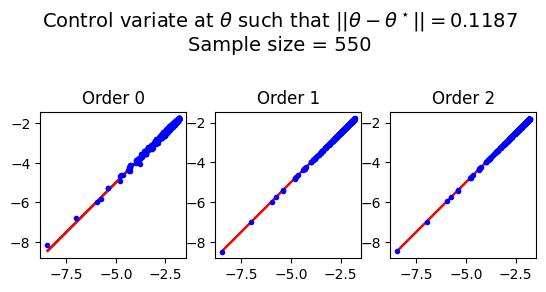

In [16]:
dens_at_thetaStar, grad_at_thetaStar, Hess_at_thetaStar = dens_at_thetaStar_Poisson, grad_at_thetaStar_Poisson, Hess_at_thetaStar_Poisson
theta = np.random.multivariate_normal(thetaStar, test_sigma, size = 1).flatten()
q_k_order0 = eval_q_k(theta, dens_at_thetaStar, grad_at_thetaStar, Hess_at_thetaStar, order = 0) 
q_k_order1 = eval_q_k(theta, dens_at_thetaStar, grad_at_thetaStar, Hess_at_thetaStar, order = 1) 
q_k_order2 = eval_q_k(theta, dens_at_thetaStar, grad_at_thetaStar, Hess_at_thetaStar, order = 2) 
l_k = analytical_grad_hess(theta, init_sigma2=0.5)[0]['log_likelihood_at_i']
fig, axs = plt.subplots(1, 3)
fig.suptitle(
    r'Control variate at $\theta$ such that $||\theta - \theta^\star|| = %3.4f$' 
    % np.linalg.norm(theta - thetaStar)
    + "\nSample size = %s" % N,
    size=14,
    y = 1.02
)
# fig.subplots_adjust(top=0.2)

for k in range(3):
        axs[k].plot(l_k, l_k, color = 'red')
        if k == 0:
            axs[k].plot(l_k, q_k_order0, '.', color = 'blue')
            axs[k].set_title('Order 0', size = 12)
        elif k == 1:
            axs[k].plot(l_k, q_k_order1, '.', color = 'blue')
            axs[k].set_title('Order 1', size = 12)
        elif k == 2:
            axs[k].plot(l_k, q_k_order2, '.', color = 'blue')
            axs[k].set_title('Order 2', size = 12)
            
        axs[k].axis('scaled')

fig.subplots_adjust(top=1.2)
plt.show()